<a href="https://colab.research.google.com/github/djsg2021utec/TESIS_MAESTRIA/blob/main/ViVIT_Filtros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

%pip install ffmpeg
from tqdm import tqdm
import time
import os
from base64 import b64encode
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import HTML
from base64 import b64encode
import glob
from random import shuffle
import tensorflow as tf
import torch
import shutil
import sys
from torch.utils.data import DataLoader, TensorDataset, random_split
import ffmpeg
from torch.cuda.amp import GradScaler, autocast


# %pip install tensorboard torchvision
# from torch.utils.tensorboard import SummaryWriter

In [ ]:
%%capture
# @title Descargar bases de datos
# @markdown ## **Tensores generados a partir de los Filtros POW, POG y PG**

# @markdown #### Una base de datos con 2000 videos capturados por medio de cámaras de videovigilancia en el mundo real. Introducido por [Cheng 2019](https://paperswithcode.com/paper/rwf-2000-an-open-large-scale-video-database).

# @markdown ### **Direcciones de los enlaces con los tensores RWFK2000(100)+POW** :
Download_POW = False # @param {type:"boolean"}
train_data_pow_pt = "https://drive.google.com/uc?id=1NnBeQDOsnwee64e0L9uC0eaTbMsYKxCd" # @param {type:"string"}
test_data_pow_pt = "https://drive.google.com/uc?id=1-04RRR3tK907arbkoJYwIukydxLyhjTW" # @param {type:"string"}

# @markdown ### **Direcciones de los enlaces con los tensores RWFK2000(100)+POG** :
Download_POG = False # @param {type:"boolean"}
train_data_pog_pt = "https://drive.google.com/uc?id=1-71k4moNyeMkFUTFaqHse6VpkvUu8CCG" # @param {type:"string"}
test_data_pog_pt = "https://drive.google.com/uc?id=1-AjEQIfPgCsrd_58j85rQLiOAT90TJ-X" # @param {type:"string"}

# @markdown ### **Direcciones de los enlaces con los tensores RWFK2000(100)+PG** :
Download_PG = True # @param {type:"boolean"}
train_data_pg_pt = "https://drive.google.com/uc?id=1sShCGPH-sa2Pj9GOz013M0Hzl-lKTAi5" # @param {type:"string"}
test_data_pg_pt = "https://drive.google.com/uc?id=1-6DVYdZnnpyLMKLB6sEG-hN1Kvtf5EN2" # @param {type:"string"}

if Download_POW:
  !gdown {train_data_pow_pt}
  !gdown {test_data_pow_pt}
if Download_POG:
  !gdown {train_data_pog_pt}
  !gdown {test_data_pog_pt}
if Download_PG:
  !gdown {train_data_pg_pt}
  !gdown {test_data_pg_pt}
# @markdown ---


In [ ]:
train_data_pt = '/content/train_data_pg.pt'
test_data_pt = '/content/test_data_pg.pt'

In [ ]:
train_data = torch.load(train_data_pt)
test_data = torch.load(test_data_pt)

## Construcción del modelo ViVit - Factorized-Self attention

In [ ]:
%pip install einops
from torch import nn, einsum
import torch
from einops.layers.torch import Rearrange
from einops import rearrange, repeat


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FSAttention(nn.Module):
    """Factorized Self-Attention"""

    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class FDAttention(nn.Module):
    """Factorized Dot-product Attention"""

    def __init__(self, dim, nt, nh, nw, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.nt = nt
        self.nh = nh
        self.nw = nw

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, d, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        qs, qt = q.chunk(2, dim=1)
        ks, kt = k.chunk(2, dim=1)
        vs, vt = v.chunk(2, dim=1)

        # Attention over spatial dimension
        qs = qs.view(b, h // 2, self.nt, self.nh * self.nw, -1)
        ks, vs = ks.view(b, h // 2, self.nt, self.nh * self.nw, -1), vs.view(b, h // 2, self.nt, self.nh * self.nw, -1)
        spatial_dots = einsum('b h t i d, b h t j d -> b h t i j', qs, ks) * self.scale
        sp_attn = self.attend(spatial_dots)
        spatial_out = einsum('b h t i j, b h t j d -> b h t i d', sp_attn, vs)

        # Attention over temporal dimension
        qt = qt.view(b, h // 2, self.nh * self.nw, self.nt, -1)
        kt, vt = kt.view(b, h // 2, self.nh * self.nw, self.nt, -1), vt.view(b, h // 2, self.nh * self.nw, self.nt, -1)
        temporal_dots = einsum('b h s i d, b h s j d -> b h s i j', qt, kt) * self.scale
        temporal_attn = self.attend(temporal_dots)
        temporal_out = einsum('b h s i j, b h s j d -> b h s i d', temporal_attn, vt)

        # return self.to_out(out)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class FSATransformerEncoder(nn.Module):
    """Factorized Self-Attention Transformer Encoder"""

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, nt, nh, nw, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(nn.ModuleList(
                [PreNorm(dim, FSAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                 PreNorm(dim, FSAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                 PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
                 ]))

    def forward(self, x):

        b = x.shape[0]
        x = torch.flatten(x, start_dim=0, end_dim=1)  # extract spatial tokens from x

        for sp_attn, temp_attn, ff in self.layers:
            sp_attn_x = sp_attn(x) + x  # Spatial attention

            # Reshape tensors for temporal attention
            sp_attn_x = sp_attn_x.chunk(b, dim=0)
            sp_attn_x = [temp[None] for temp in sp_attn_x]
            sp_attn_x = torch.cat(sp_attn_x, dim=0).transpose(1, 2)
            sp_attn_x = torch.flatten(sp_attn_x, start_dim=0, end_dim=1)

            temp_attn_x = temp_attn(sp_attn_x) + sp_attn_x  # Temporal attention

            x = ff(temp_attn_x) + temp_attn_x  # MLP

            # Again reshape tensor for spatial attention
            x = x.chunk(b, dim=0)
            x = [temp[None] for temp in x]
            x = torch.cat(x, dim=0).transpose(1, 2)
            x = torch.flatten(x, start_dim=0, end_dim=1)

        # Reshape vector to [b, nt*nh*nw, dim]
        x = x.chunk(b, dim=0)
        x = [temp[None] for temp in x]
        x = torch.cat(x, dim=0)
        x = torch.flatten(x, start_dim=1, end_dim=2)
        return x


class FDATransformerEncoder(nn.Module):
    """Factorized Dot-product Attention Transformer Encoder"""

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, nt, nh, nw, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(
                PreNorm(dim, FDAttention(dim, nt, nh, nw, heads=heads, dim_head=dim_head, dropout=dropout)))

    def forward(self, x):
        for attn in self.layers:
            x = attn(x) + x

        return x


class ViViTBackbone(nn.Module):
    """ Model-3 backbone of ViViT """

    def __init__(self, t, h, w, patch_t, patch_h, patch_w, num_classes, dim, depth, heads, mlp_dim, dim_head=3,
                 channels=3, mode='tubelet', device='cuda', emb_dropout=0., dropout=0., model=3):
        super().__init__()

        assert t % patch_t == 0 and h % patch_h == 0 and w % patch_w == 0, "Video dimensions should be divisible by " \
                                                                           "tubelet size "

        self.T = t
        self.H = h
        self.W = w
        self.channels = channels
        self.t = patch_t
        self.h = patch_h
        self.w = patch_w
        self.mode = mode
        self.device = device

        self.nt = self.T // self.t
        self.nh = self.H // self.h
        self.nw = self.W // self.w

        tubelet_dim = self.t * self.h * self.w * channels

        self.to_tubelet_embedding = nn.Sequential(
            Rearrange('b c (t pt) (h ph) (w pw) -> b t (h w) (pt ph pw c)', pt=self.t, ph=self.h, pw=self.w),
            nn.Linear(tubelet_dim, dim)
        )

        # repeat same spatial position encoding temporally
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, self.nh * self.nw, dim)).repeat(1, self.nt, 1, 1)

        self.dropout = nn.Dropout(emb_dropout)

        if model == 3:
            self.transformer = FSATransformerEncoder(dim, depth, heads, dim_head, mlp_dim,
                                                     self.nt, self.nh, self.nw, dropout)
        elif model == 4:
            assert heads % 2 == 0, "Number of heads should be even"
            self.transformer = FDATransformerEncoder(dim, depth, heads, dim_head, mlp_dim,
                                                     self.nt, self.nh, self.nw, dropout)

        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        """ x is a video: (b, C, T, H, W) """

        tokens = self.to_tubelet_embedding(x)

        tokens += self.pos_embedding.to(device)
        tokens = self.dropout(tokens)

        x = self.transformer(tokens)
        x = x.mean(dim=1)

        x = self.to_latent(x)
        return self.mlp_head(x)


# if __name__ == '__main__':
#     device = torch.device('cuda')
#     x = torch.rand(32, 3, 32, 64, 64).to(device)

#     vivit = ViViTBackbone(32, 64, 64, 8, 4, 4, 10, 512, 6, 10, 8, model=3).to(device)
#     out = vivit(x)
#     print(out)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00


## Entrenamiento del modelo

In [ ]:
def train_model(train_data, test_data, model_class, num_epochs=200, lr=0.001, weight_decay=0.0001, batch_size=16):
    # Configuración del modelo y del dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.backends.cudnn.benchmark = False

    model = model_class.to(device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Variables para almacenar métricas
    loss_values, val_loss_values = [], []
    train_accuracy_values, val_accuracy_values = [], []

    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        # ...
        # Lógica de entrenamiento y validación
        # ...
        avg_loss = 0
        num_batches = 0

        train_correct = 0
        train_total = 0

        for videos_batch, labels_batch in train_loader:
            with autocast():
              videos_batch, labels_batch = videos_batch.to(device), labels_batch.to(device)
              videos_batch=videos_batch.permute(0, 2, 1, 3, 4).float()
              # Propagación hacia adelante

              predictions = model(videos_batch)
              loss = criterion(predictions, labels_batch)

            # Propagación hacia atrás y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            num_batches += 1

            _, train_predicted = torch.max(predictions.data, 1)
            train_total += labels_batch.size(0)
            train_correct += (train_predicted == labels_batch).sum().item()

        avg_loss /= num_batches
        loss_values.append(avg_loss)

        train_accuracy = 100 * train_correct / train_total
        train_accuracy_values.append(train_accuracy)

        # Evaluación en el conjunto de validación
        y_true, y_pred = [], []

        model.eval()
        val_loss = 0
        val_batches = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for val_videos_batch, val_labels_batch in test_loader:
                val_videos_batch, val_labels_batch = val_videos_batch.to(device), val_labels_batch.to(device)
                val_videos_batch=val_videos_batch.permute(0, 2, 1, 3, 4).float()
                val_predictions = model(val_videos_batch)
                val_loss_batch = criterion(val_predictions, val_labels_batch)
                val_loss += val_loss_batch.item()
                # Almacenar las probabilidades de las predicciones y las etiquetas verdaderas
                probabilities = torch.nn.functional.softmax(val_predictions, dim=1)
                y_pred.extend(probabilities[:, 1].cpu().numpy())
                y_true.extend(val_labels_batch.cpu().numpy())

                _, predicted = torch.max(val_predictions.data, 1)
                total += val_labels_batch.size(0)
                correct += (predicted == val_labels_batch).sum().item()

                val_batches += 1

        val_loss /= val_batches
        val_loss_values.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracy_values.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}, Validation Acc: {val_accuracy:.2f}%")
        # Limpieza de la memoria de la GPU al final de cada época
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    # Devolver las métricas recolectadas
    return loss_values, val_loss_values, train_accuracy_values, val_accuracy_values, y_true, y_pred



In [ ]:
num_epochs = 200
lr = 0.001
weight_decay= 0.0001
batch_size=16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vivit = ViViTBackbone(
    t=150,
    h=224,
    w=224,
    patch_t=75,
    patch_h=14,
    patch_w=14,
    num_classes=2,  # Solo hay 2 clases: violencia y no violencia
    dim=128, #224
    depth=6,
    heads=20,
    mlp_dim=5,
    model=3
)
parameters = filter(lambda p: p.requires_grad, vivit.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Número de parámetros entrenables: %.3fM' % parameters)


Número de parámetros entrenables: 6.029M


In [ ]:


# Luego puedes llamar a la función con tus datos y modelo
loss_values, val_loss_values, train_accuracy_values, val_accuracy_values, y_true, y_pred = train_model(train_data, test_data,vivit,num_epochs, lr, weight_decay, batch_size)

Epoch [1/200], Train Loss: 1.3908, Validation Loss: 1.3241, Train Acc: 52.50, Validation Acc: 50.00%
Epoch [2/200], Train Loss: 0.8378, Validation Loss: 0.6477, Train Acc: 50.00, Validation Acc: 50.00%
Epoch [3/200], Train Loss: 0.7125, Validation Loss: 0.6154, Train Acc: 50.00, Validation Acc: 50.00%
Epoch [4/200], Train Loss: 0.7650, Validation Loss: 0.6196, Train Acc: 50.00, Validation Acc: 50.00%
Epoch [5/200], Train Loss: 0.7220, Validation Loss: 0.6744, Train Acc: 50.00, Validation Acc: 50.00%
Epoch [6/200], Train Loss: 0.6921, Validation Loss: 0.7468, Train Acc: 52.50, Validation Acc: 50.00%
Epoch [7/200], Train Loss: 0.6987, Validation Loss: 0.7454, Train Acc: 50.00, Validation Acc: 50.00%
Epoch [8/200], Train Loss: 0.6966, Validation Loss: 0.6985, Train Acc: 51.25, Validation Acc: 55.00%
Epoch [9/200], Train Loss: 0.6937, Validation Loss: 0.6682, Train Acc: 45.00, Validation Acc: 50.00%
Epoch [10/200], Train Loss: 0.6944, Validation Loss: 0.6625, Train Acc: 50.00, Validation A

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_graph(loss_values, val_loss_values,name_experiment="POW"):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
    plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - {name_experiment}')
    plt.legend()
    plt.show()

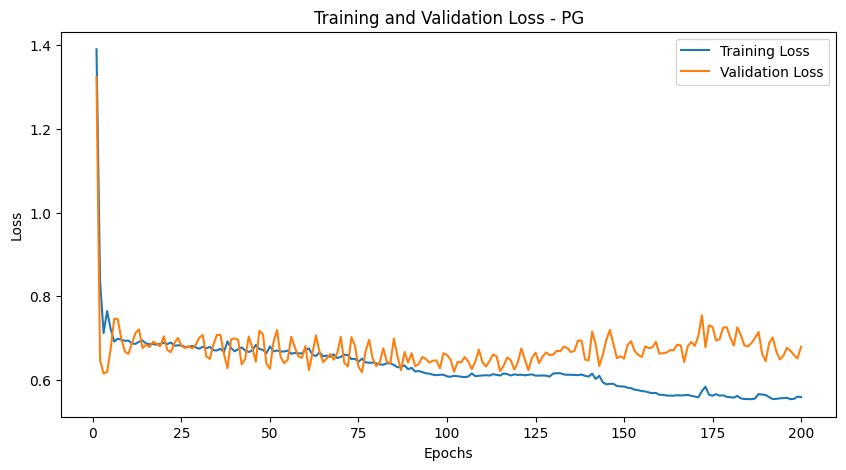

In [ ]:
plot_loss_graph(loss_values, val_loss_values,name_experiment="PG")

In [ ]:
def plot_accuracy_graph(train_accuracy_values, val_accuracy_values,name_experiment, window_size=5):
    def moving_average(data, window_size):
        return [sum(data[i:i+window_size]) / window_size for i in range(len(data) - window_size + 1)]

    # Calcular el promedio móvil
    smoothed_train_accuracy = moving_average(train_accuracy_values, window_size)
    smoothed_val_accuracy = moving_average(val_accuracy_values, window_size)

    # Graficar las curvas de precisión
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(smoothed_train_accuracy) + 1), smoothed_train_accuracy, label='Smoothed Training Accuracy', color='blue')
    plt.plot(range(1, len(smoothed_val_accuracy) + 1), smoothed_val_accuracy, label='Smoothed Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title(f'Training and Validation Accuracy Curves - Smoothed - {name_experiment}')
    plt.grid(True)
    plt.show()

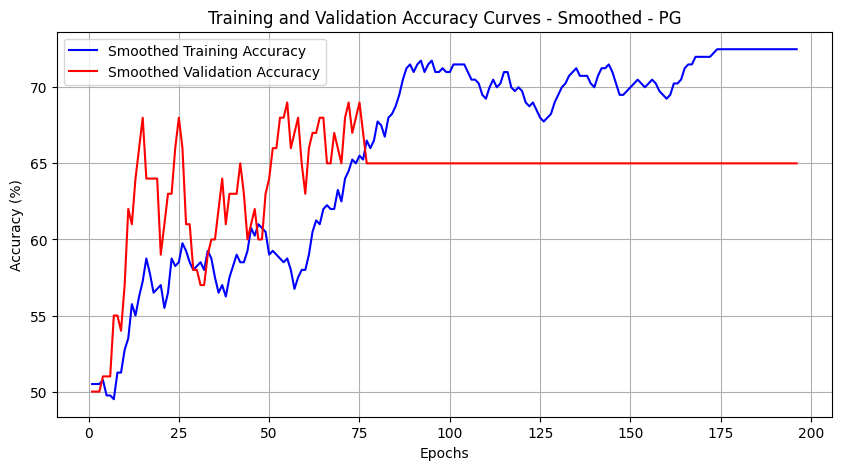

In [ ]:
plot_accuracy_graph(train_accuracy_values, val_accuracy_values,name_experiment="PG")

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred,name_experiment):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {name_experiment}')
    plt.legend(loc="lower right")
    plt.show()

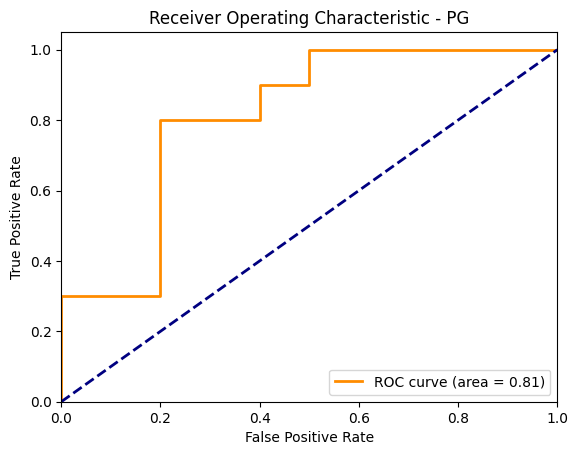

In [ ]:
plot_roc_curve(y_true, y_pred,name_experiment="PG")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def convert_probabilities_to_class(y_pred, threshold=0.5):
    y_pred_array = np.array(y_pred)  # Convertir la lista a un array de NumPy
    return np.where(y_pred_array > threshold, 1, 0)

# Uso de la función
y_pred_class = convert_probabilities_to_class(y_pred)

def plot_confusion_matrix(y_true, y_pred_class, name_experiment="Experiment"):
    conf_matrix = confusion_matrix(y_true, y_pred_class)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name_experiment}')
    plt.show()

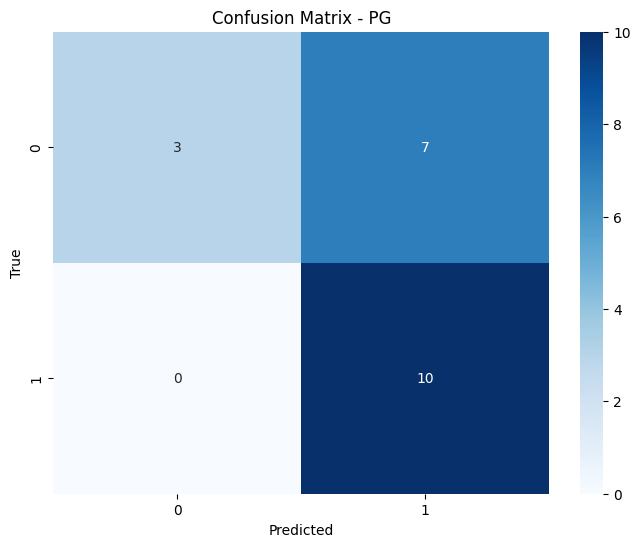

In [ ]:
y_pred_class = convert_probabilities_to_class(y_pred, threshold=0.5)
plot_confusion_matrix(y_true, y_pred_class, name_experiment="PG")